# **Modelo GRU - Séries Temporais**

###  Notebook: `03_08_C2_GRU`

##  Modelo GRU para predição

---


___

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import math
import requests
import json
import os
import statsmodels.api as sm
import tensorflow as tf
from pandas import concat
import scipy.stats as st

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

import math

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [3]:
pd.options.display.float_format = '{:,.2f}'.format

# Ajustar parâmetros de plotagem

plt.rcParams["text.color"] = 'Black'
plt.rcParams["axes.titlesize"] = 20
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["figure.figsize"] = [15, 6]
plt.rcParams["lines.linewidth"] = 2.0
plt.rcParams['grid.alpha'] = 0.90
plt.rcParams['axes.facecolor'] = 'whitesmoke'
plt.rcParams['lines.markersize'] = 8.0

## 1. Importando os datasets

In [4]:
dataset_cluster2_series = pd.read_csv("datasets//dataset_cluster2_series.csv", header=0, index_col=0)
dataset_cluster2_validacao = pd.read_csv("datasets//dataset_cluster2_validation.csv", header=0, index_col=0)

dataset_cluster2_series = dataset_cluster2_series.append(dataset_cluster2_validacao)

In [5]:
np.random.seed(10)

## 2. Preparando o dataset para a rede neural GRU

In [6]:
serie_cluster2 = np.array(dataset_cluster2_series)

In [7]:
print(serie_cluster2)

[[1.04000000e+02 7.60000000e-01 1.63200000e+01 ... 1.10700000e+03
  7.30970152e+08 6.70972820e+09]
 [1.03100000e+02 6.10000000e-01 1.63000000e+01 ... 2.55900000e+03
  4.15087444e+09 5.84414384e+09]
 [1.13000000e+02 4.70000000e-01 1.61900000e+01 ... 4.30200000e+03
  3.77861435e+09 5.75759405e+09]
 ...
 [1.01200000e+02 8.60000000e-01 1.90000000e+00 ... 8.31900000e+03
  2.68586194e+10 3.26409023e+10]
 [1.04100000e+02 8.90000000e-01 1.90000000e+00 ... 9.33800000e+03
  2.20785725e+10 2.66353020e+10]
 [1.10200000e+02 1.35000000e+00 1.90000000e+00 ... 1.26730000e+04
  1.85607303e+10 2.91025891e+10]]


### 2.1 Convertendo o array em um modelo de dados 3D para entrada na rede GRU

---
Créditos: https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

Para fazer a predição, utilizei os 12 primeiros meses para predizer o seguinte. Com isso, o dataset perde 12 meses, uma vez que os 11 primeiros meses não possuem 12 meses anteriores e o último mês não possui valor conhecido da arrecadação do mês subsequente.

___

In [8]:
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
 
raw = DataFrame()
raw['ob1'] = [x for x in range(10)]
raw['ob2'] = [x for x in range(50, 60)]
# values = raw.values
values = pd.DataFrame(serie_cluster2).values
serie_cluster2_prepared = series_to_supervised(values,12)
print(serie_cluster2_prepared)

     var1(t-12)  var2(t-12)  var3(t-12)  var4(t-12)  var5(t-12)  var6(t-12)  \
12       104.00        0.76       16.32      136.19       98.59       10.00   
13       103.10        0.61       16.30      139.84       99.45       10.00   
14       113.00        0.47       16.19      138.89      111.98       10.00   
15       107.80        0.37       15.96      138.85      107.36        9.75   
16       108.90        0.51       15.77      148.25      106.03        9.75   
..          ...         ...         ...         ...         ...         ...   
199       97.90        0.11        5.90      114.23      141.78        5.95   
200      101.70       -0.04        5.71      117.25      138.26        5.95   
201      102.50        0.10        5.38      116.42      142.80        5.57   
202       99.40        0.51        4.90      117.74      138.83        5.57   
203      100.60        1.15        4.59      114.94      137.50        5.57   

      var7(t-12)  var8(t-12)  var9(t-12)       var1

### 2.3 Dividindo o dataset em sets de treino, teste e predição

In [9]:
# Divide em conjuntos de treino e teste e predição
values = serie_cluster2_prepared.values
# Base de treino com 168 meses
periodo_treino = 144
train = values[:periodo_treino, :]
test = values[periodo_treino:180, :]
predict = values[180:, :]


In [10]:
# Divide em entradas e saídas
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
predict_X, predict_y = predict[:, :-1], predict[:, -1]



### Normalizando os datasets

In [11]:
## Criando um scaler para o campo de saída


scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))
scaler_predict_X = MinMaxScaler(feature_range=(0, 1))
scaler_predict_y = MinMaxScaler(feature_range=(0, 1))

train_X = scaler_X.fit_transform(train_X)
test_X = scaler_X.fit_transform(test_X)

train_y = scaler_y.fit_transform(train_y.reshape(-1,1))
test_y = scaler_y.fit_transform(test_y.reshape(-1,1))

predict_X = scaler_predict_X.fit_transform(predict_X)
predict_y = scaler_predict_y.fit_transform(predict_y.reshape(-1,1))



In [12]:
# Reformata o array 3D 
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
predict_X = predict_X.reshape((predict_X.shape[0], 1, predict_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape,predict_X.shape, predict_y.shape)

(144, 1, 142) (144, 1) (36, 1, 142) (36, 1) (12, 1, 142) (12, 1)


## 3. Implementando o modelo GRU


In [13]:
train_X.shape

(144, 1, 142)

In [14]:
#Função para calculo do MAPE - Mean Absolute Percentage Error, que será  utilizado como medida de erro do modelo

def calculo_mape(y_pred,y_true):

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [15]:

np.random.seed(10)

# Criando a rede

model = Sequential()
model.add(GRU(15, return_sequences= True, input_shape=(train_X.shape[1], train_X.shape[2])))

model.add(Dense(1))


model.compile(loss='mean_squared_error', optimizer='Adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=32, 
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)



Epoch 1/50
5/5 - 1s - loss: 0.1324 - val_loss: 0.1023
Epoch 2/50
5/5 - 0s - loss: 0.0339 - val_loss: 0.0377
Epoch 3/50
5/5 - 0s - loss: 0.0604 - val_loss: 0.0304
Epoch 4/50
5/5 - 0s - loss: 0.0483 - val_loss: 0.0360
Epoch 5/50
5/5 - 0s - loss: 0.0281 - val_loss: 0.0567
Epoch 6/50
5/5 - 0s - loss: 0.0224 - val_loss: 0.0681
Epoch 7/50
5/5 - 0s - loss: 0.0206 - val_loss: 0.0602
Epoch 8/50
5/5 - 0s - loss: 0.0185 - val_loss: 0.0467
Epoch 9/50
5/5 - 0s - loss: 0.0183 - val_loss: 0.0397
Epoch 10/50
5/5 - 0s - loss: 0.0184 - val_loss: 0.0400
Epoch 11/50
5/5 - 0s - loss: 0.0175 - val_loss: 0.0442
Epoch 12/50
5/5 - 0s - loss: 0.0169 - val_loss: 0.0469
Epoch 13/50
5/5 - 0s - loss: 0.0166 - val_loss: 0.0455
Epoch 14/50
5/5 - 0s - loss: 0.0161 - val_loss: 0.0421
Epoch 15/50
5/5 - 0s - loss: 0.0157 - val_loss: 0.0399
Epoch 16/50
5/5 - 0s - loss: 0.0154 - val_loss: 0.0398
Epoch 17/50
5/5 - 0s - loss: 0.0150 - val_loss: 0.0406
Epoch 18/50
5/5 - 0s - loss: 0.0147 - val_loss: 0.0408
Epoch 19/50
5/5 - 0

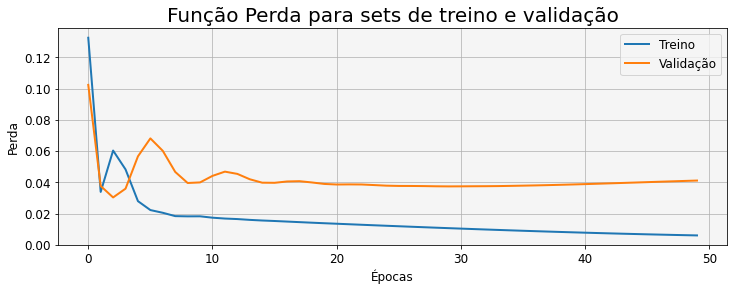

In [16]:
# Perda nos sets de treino e validação
plt.rcParams['grid.alpha'] = 0.90
plt.rcParams['axes.facecolor'] = 'whitesmoke'

plt.figure(figsize=(12,4))
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Função Perda para sets de treino e validação')
plt.grid(True)
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()


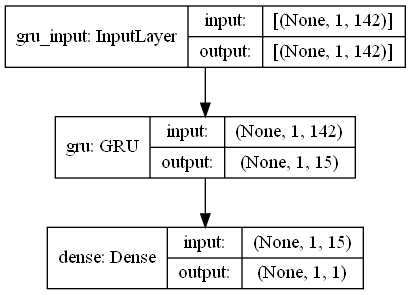

In [17]:

plot_model(model, show_shapes=True)

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 1, 15)             7155      
_________________________________________________________________
dense (Dense)                (None, 1, 1)              16        
Total params: 7,171
Trainable params: 7,171
Non-trainable params: 0
_________________________________________________________________


# 4. Fazendo a validação para o período de 2017 a 2019

In [19]:
# Realizando a predição


yhat = model.predict(test_X)
test_X_final = test_X.reshape(test_X.shape[0], test_X.shape[2])

# invertendo a normalização para apresentar a previsão

yhat_reshaped = yhat.reshape(len(yhat),1)
inv_yhat = np.concatenate((yhat_reshaped, test_X_final[:, :-1]), axis=1)

inv_yhat = inv_yhat[:,0]

test_y_final = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y_final, test_X_final[:, 1:]), axis=1)

inv_y = inv_y[:,0]


# Calculando RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))


print('Test RMSE: %.3f' % rmse)



Test RMSE: 0.203


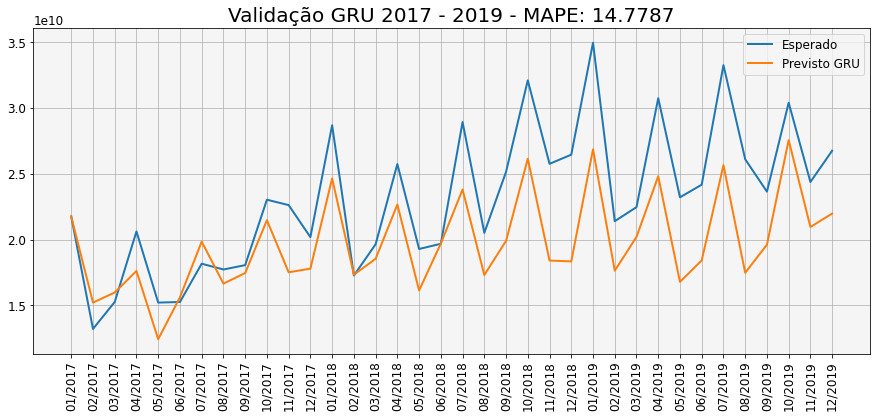

In [20]:
test_y_inv = scaler_y.inverse_transform(test_y_final)
yhat_final_inv = scaler_y.inverse_transform(yhat_reshaped)
df_data = pd.date_range('2017-01','2020-01', freq = 'm')


# Plota o valor observado vs previsto. 

plt.figure(figsize=(15,6))
plt.plot(test_y_inv, label='Esperado')
plt.plot(yhat_final_inv, label='Previsto GRU')
plt.legend()
plt.title('Validação GRU 2017 - 2019 - MAPE: %.4f' % calculo_mape(yhat_final_inv, test_y_inv))
plt.xticks(np.arange(len(test_y_inv)),df_data.strftime('%m/%Y'), rotation='vertical')
plt.grid(True)
plt.show()

In [21]:
variacao_percentual = pd.DataFrame(((test_y_inv/yhat_final_inv)-1) ,columns=['variacao'])

In [22]:
set_alerta_negativo = pd.DataFrame()
set_normal= pd.DataFrame()
set_alerta_positivo = pd.DataFrame()

In [23]:
for i in range (len(variacao_percentual)):
    if variacao_percentual.iloc[i].values[0] > 0.05:
        set_alerta_positivo = set_alerta_positivo.append(variacao_percentual[i:i+1])
    elif variacao_percentual.iloc[i].values[0] < -0.05:
        set_alerta_negativo = set_alerta_negativo.append(variacao_percentual[i:i+1])
    else:
        set_normal = set_normal.append(variacao_percentual[i:i+1])

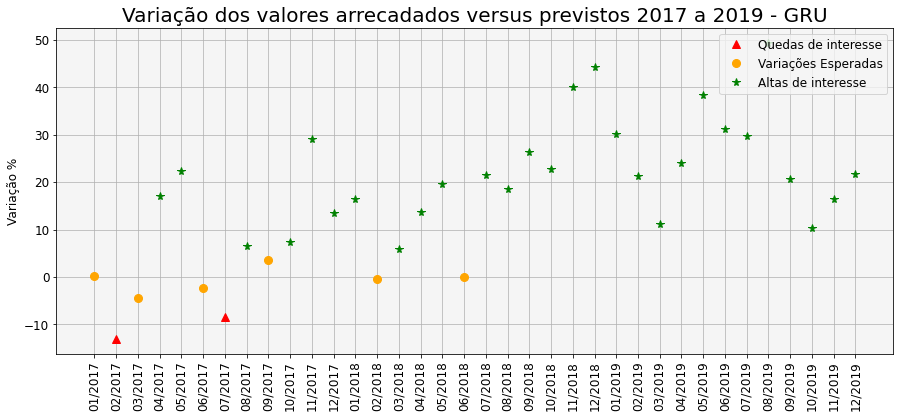

In [24]:
df_data = pd.date_range('2017-01','2020-01', freq = 'm')

#Plota o resultado do modelo
fig, ax = plt.subplots(figsize=(15,6))
ax.set_ylabel('Variação %')

if len(set_alerta_negativo) > 0:
    plt.plot(set_alerta_negativo * 100, 'g^', 
             color='red',  label='Quedas de interesse')

if len(set_normal) > 0:
    plt.plot(set_normal * 100, 'o', color='orange',  label='Variações Esperadas')

if len(set_alerta_positivo) > 0:
    plt.plot(set_alerta_positivo * 100, '*', color='green',  label='Altas de interesse')

plt.title('Variação dos valores arrecadados versus previstos 2017 a 2019 - GRU' )
plt.grid(True)
ax.set_xticks(range(len(df_data)))
plt.xticks(ax.get_xticks(), df_data.strftime('%m/%Y'), rotation='vertical')
plt.legend(loc='upper right')

# 5. Predição para 2020

In [25]:
# Realizando a predição

yhat = model.predict(predict_X)
predict_X_final = predict_X.reshape(predict_X.shape[0], predict_X.shape[2])

# Invertendo a escala para apresentar a previsão

yhat_reshaped = yhat.reshape(len(yhat),1)
inv_yhat = np.concatenate((yhat_reshaped, predict_X_final[:, :-1]), axis=1)

inv_yhat = inv_yhat[:,0]
predict_y_final = predict_y.reshape((len(predict_y), 1))
inv_y = np.concatenate((predict_y_final, predict_X_final[:, 1:]), axis=1)

inv_y = inv_y[:,0]

# Calculando o RMSE e o MAPE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))

# mape = calculo_mape(inv_yhat, inv_y)
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.185


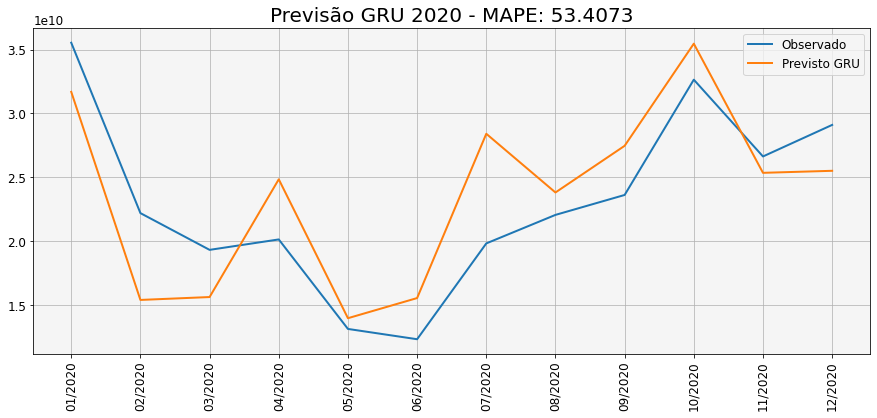

In [26]:
predict_y_inv = scaler_predict_y.inverse_transform(predict_y_final)
yhat_final_inv = scaler_predict_y.inverse_transform(yhat_reshaped)


df_data = pd.date_range('2020-01','2021-01', freq = 'm')

# Plota o valor observado vs previsto. 

plt.figure(figsize=(15,6))
plt.plot(predict_y_inv, label='Observado')
plt.plot(yhat_final_inv, label='Previsto GRU')
plt.legend()
plt.title('Previsão GRU 2020 - MAPE: %.4f' % calculo_mape(yhat_final_inv[0], predict_y_inv))
plt.xticks(np.arange(len(predict_y_inv)),df_data.strftime('%m/%Y'), rotation='vertical')
plt.grid(True)
plt.show()


In [27]:
variacao_percentual = pd.DataFrame(((predict_y_inv/yhat_final_inv)-1) ,columns=['variacao'])

In [28]:
set_alerta_negativo = pd.DataFrame()
set_normal= pd.DataFrame()
set_alerta_positivo = pd.DataFrame()

In [29]:
for i in range (len(variacao_percentual)):
    if variacao_percentual.iloc[i].values[0] > 0.05:
        set_alerta_positivo = set_alerta_positivo.append(variacao_percentual[i:i+1])
    elif variacao_percentual.iloc[i].values[0] < -0.05:
        set_alerta_negativo = set_alerta_negativo.append(variacao_percentual[i:i+1])
    else:
        set_normal = set_normal.append(variacao_percentual[i:i+1])
        
        

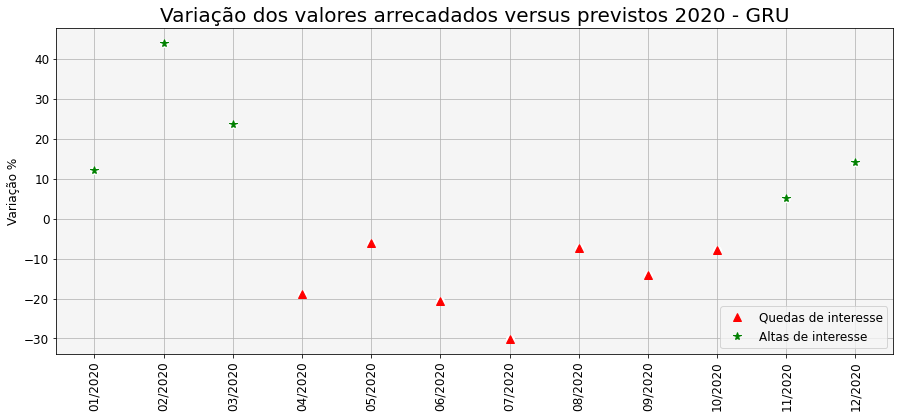

In [30]:
df_data = pd.date_range('2020-01','2021-01', freq = 'm')

#Plota o resultado do modelo
fig, ax = plt.subplots(figsize=(15,6))
ax.set_ylabel('Variação %')

plt.plot(variacao_percentual * 100, 'o', color='white')

if len(set_alerta_negativo) > 0:
    plt.plot(set_alerta_negativo * 100, 'g^', 
             color='red',  label='Quedas de interesse')

if len(set_normal) > 0:
    plt.plot(set_normal * 100, 'o', color='orange',  label='Variações Esperadas')

if len(set_alerta_positivo) > 0:
    plt.plot(set_alerta_positivo * 100, '*', color='green',  label='Altas de interesse')
    
plt.title('Variação dos valores arrecadados versus previstos 2020 - GRU' )
plt.grid(True)
ax.set_xticks(range(0,12))
plt.xticks(ax.get_xticks(), df_data.strftime('%m/%Y'), rotation='vertical')
plt.legend(loc='lower right')